#### Imports

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from glob import glob
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import shap


#### Station Dataframe

In [19]:
stations = pd.read_csv('data/current_bluebikes_stations.csv')
stations

,Number,Name,Latitude,Longitude,District,Public,Total docks
0,K32015,1200 Beacon St,42.344149,-71.114674,Brookline,Yes,15
1,W32006,160 Arsenal St,42.364664,-71.175694,Watertown,Yes,11
2,A32019,175 N Harvard St,42.364475,-71.128408,Boston,Yes,17
3,S32035,191 Beacon St,42.380323,-71.108786,Somerville,Yes,19
4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17
...,...,...,...,...,...,...,...
416,D32022,West End Park,42.365908,-71.064467,Boston,Yes,35
417,N32005,West Newton,42.349601,-71.226275,Newton,Yes,15
418,B32059,Whittier St Health Center,42.332863,-71.092189,Boston,Yes,19
419,D32040,Williams St at Washington St,42.306539,-71.107669,Boston,Yes,23


In [20]:
stations_gpd = gpd.GeoDataFrame(stations, geometry = gpd.points_from_xy(
    stations['Longitude'],
    stations['Latitude']
),crs="EPSG:4326")
stations_gpd.explore()

In [21]:
weather = pd.read_csv('data/boston_weather.csv')
weather = weather[['datetime','temp','humidity','precip','snow','windspeed','visibility']]
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather =weather.rename({'datetime':'date'},axis=1)

In [24]:
# Match any YYYY-MM-bluebikes-tripdata.csv in "data/" folder
csv_files = sorted(glob("data/*-bluebikes-tripdata.csv"))

dfs = []
for f in csv_files:
    try:
        df = pd.read_csv(f)
        dfs.append(df)
    except Exception as e:
        print(f"❌ Failed to load {f}: {e}")

if dfs:
    trips = pd.concat(dfs, ignore_index=True)
    print(f"✅ Combined shape: {trips.shape}")
else:
    print("❌ No CSVs loaded. Check filename pattern or folder.")

✅ Combined shape: (8793350, 13)


In [35]:
cols = ['ride_id','rideable_type','started_at','start_station_name',
        'start_station_id','start_lat','start_lng','member_casual']
trips = trips[cols]
trips=trips.dropna()
trips['date'] = pd.to_datetime(pd.to_datetime(trips['started_at'],format='mixed').dt.date)
trips

,ride_id,rideable_type,started_at,start_station_name,start_station_id,start_lat,start_lng,member_casual,date
0,C694F27EDA2FB2A3,docked_bike,2023-07-18 13:48:34,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,42.331184,-71.095171,member,2023-07-18
1,E182C085A7901BD0,docked_bike,2023-07-19 12:16:30,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,42.331184,-71.095171,member,2023-07-19
2,EEAB121638F88C65,docked_bike,2023-07-28 17:49:26,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,42.331184,-71.095171,member,2023-07-28
3,1A1EAD7F0B0D3EC9,docked_bike,2023-07-22 23:14:17,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,42.331184,-71.095171,member,2023-07-22
4,53822DB5B536A35B,docked_bike,2023-07-21 18:41:22,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,42.331184,-71.095171,member,2023-07-21
...,...,...,...,...,...,...,...,...,...
8793345,12C988590CD48734,electric_bike,2025-06-12 20:20:45.355,Tremont St at Northampton St,C32056,42.338432,-71.081690,member,2025-06-12
8793346,B89B012C3FF93D93,classic_bike,2025-06-25 17:13:30.010,Park Street T Stop - Tremont St at Park St,B32068,42.356627,-71.062457,member,2025-06-25
8793347,F97E96820125E8D2,classic_bike,2025-06-09 16:03:20.398,Innovation Lab - 125 Western Ave at Batten Way,A32011,42.363713,-71.124598,member,2025-06-09
8793348,9817CCD579D4E6DD,classic_bike,2025-06-03 09:22:41.353,Centre St at Seaverns Ave,E32008,42.313580,-71.114050,member,2025-06-03


In [43]:
# Filter to June 2025 only
trips_may = trips[(trips['date'] >= '2025-06-01') & (trips['date'] <= '2025-06-30')]

# Get station IDs active in May 2025
active_stations = trips_may['start_station_id'].unique()
trips_active = trips[trips['start_station_id'].isin(active_stations)]
trips_active

,ride_id,rideable_type,started_at,start_station_name,start_station_id,start_lat,start_lng,member_casual,date
0,C694F27EDA2FB2A3,docked_bike,2023-07-18 13:48:34,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,42.331184,-71.095171,member,2023-07-18
1,E182C085A7901BD0,docked_bike,2023-07-19 12:16:30,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,42.331184,-71.095171,member,2023-07-19
2,EEAB121638F88C65,docked_bike,2023-07-28 17:49:26,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,42.331184,-71.095171,member,2023-07-28
3,1A1EAD7F0B0D3EC9,docked_bike,2023-07-22 23:14:17,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,42.331184,-71.095171,member,2023-07-22
4,53822DB5B536A35B,docked_bike,2023-07-21 18:41:22,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,42.331184,-71.095171,member,2023-07-21
...,...,...,...,...,...,...,...,...,...
8793345,12C988590CD48734,electric_bike,2025-06-12 20:20:45.355,Tremont St at Northampton St,C32056,42.338432,-71.081690,member,2025-06-12
8793346,B89B012C3FF93D93,classic_bike,2025-06-25 17:13:30.010,Park Street T Stop - Tremont St at Park St,B32068,42.356627,-71.062457,member,2025-06-25
8793347,F97E96820125E8D2,classic_bike,2025-06-09 16:03:20.398,Innovation Lab - 125 Western Ave at Batten Way,A32011,42.363713,-71.124598,member,2025-06-09
8793348,9817CCD579D4E6DD,classic_bike,2025-06-03 09:22:41.353,Centre St at Seaverns Ave,E32008,42.313580,-71.114050,member,2025-06-03


In [45]:
daily_counts = (
    trips_active.groupby(['start_station_id', 'start_station_name', 'date'])
                .size()
                .reset_index(name='trip_count')
)
daily_counts

,start_station_id,start_station_name,date,trip_count
0,A32000,Fan Pier,2023-07-01,30
1,A32000,Fan Pier,2023-07-02,20
2,A32000,Fan Pier,2023-07-03,28
3,A32000,Fan Pier,2023-07-04,35
4,A32000,Fan Pier,2023-07-05,41
...,...,...,...,...
316072,ZZ32996,Auburn St. at Mystic River,2025-06-26,5
316073,ZZ32996,Auburn St. at Mystic River,2025-06-27,6
316074,ZZ32996,Auburn St. at Mystic River,2025-06-28,2
316075,ZZ32996,Auburn St. at Mystic River,2025-06-29,6


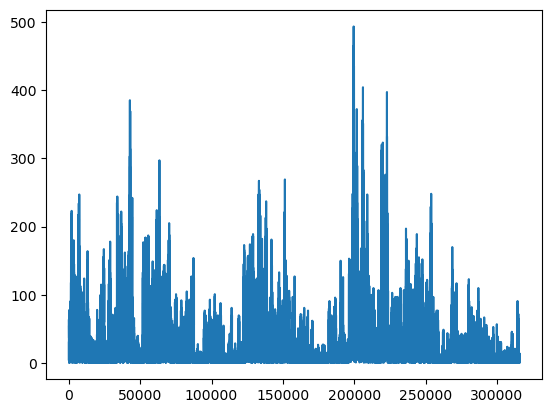

In [46]:
daily_counts['trip_count'].plot();

top 10 busiest for the 2 years

In [47]:
daily_counts.groupby('start_station_name')['trip_count'].sum().sort_values(ascending=False)[:10]

start_station_name
MIT at Mass Ave / Amherst St                                   168000
Central Square at Mass Ave / Essex St                          129261
Harvard Square at Mass Ave/ Dunster                            115211
MIT Vassar St                                                   96871
MIT Pacific St at Purrington St                                 93428
Charles Circle - Charles St at Cambridge St                     88383
Ames St at Main St                                              85390
Christian Science Plaza - Massachusetts Ave at Westland Ave     78519
Mass Ave/Lafayette Square                                       76627
Beacon St at Massachusetts Ave                                  74384
Name: trip_count, dtype: int64

In [119]:
def create_features(df,label=None):
    out = df.copy()
    # Monday(0) - Sunday (6)
    out['dayofweek'] = out['date'].dt.dayofweek
    out['is_weekend'] = out['dayofweek'] >= 5
    out['quarter'] = out['date'].dt.quarter ##
    out['year'] = out['date'].dt.year ##
    out['month'] = out['date'].dt.month ## 
    out['dayofyear'] = out['date'].dt.dayofyear ##
    out['dayofmonth'] = out['date'].dt.day ##
    out['weekofyear'] = out['date'].dt.isocalendar().week ##
   
    def assign_season(month):
        if month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Fall'
        else:
            return 'Winter'

    out['season'] = out['month'].apply(assign_season)
    
    out = out.sort_values(['start_station_id', 'date'])

    out['lag_1'] = out.groupby('start_station_id')['trip_count'].shift(1)

    out['lag_7'] = out.groupby('start_station_id')['trip_count'].shift(7)
    
    out['rolling_7'] = (
        out.groupby('start_station_id')['trip_count']
           .shift(1)  # Exclude today
           .rolling(window=7)
           .mean()
           .reset_index(level=0, drop=True)
    )

    # One-hot encode season
    out = pd.get_dummies(out, columns=['season'])

    X = out
    if label:
        y = out[label]
        return X, y
    return X

In [120]:
daily_counts_wft = create_features(daily_counts)
daily_counts_wft

,start_station_id,start_station_name,date,trip_count,dayofweek,is_weekend,quarter,year,month,dayofyear,dayofmonth,weekofyear,lag_1,lag_7,rolling_7,season_Fall,season_Spring,season_Summer,season_Winter
0,A32000,Fan Pier,2023-07-01,30,5,True,3,2023,7,182,1,26,NaN,NaN,NaN,False,False,True,False
1,A32000,Fan Pier,2023-07-02,20,6,True,3,2023,7,183,2,26,30.0,NaN,NaN,False,False,True,False
2,A32000,Fan Pier,2023-07-03,28,0,False,3,2023,7,184,3,27,20.0,NaN,NaN,False,False,True,False
3,A32000,Fan Pier,2023-07-04,35,1,False,3,2023,7,185,4,27,28.0,NaN,NaN,False,False,True,False
4,A32000,Fan Pier,2023-07-05,41,2,False,3,2023,7,186,5,27,35.0,NaN,NaN,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316072,ZZ32996,Auburn St. at Mystic River,2025-06-26,5,3,False,2,2025,6,177,26,26,3.0,5.0,5.142857,False,False,True,False
316073,ZZ32996,Auburn St. at Mystic River,2025-06-27,6,4,False,2,2025,6,178,27,26,5.0,8.0,5.142857,False,False,True,False
316074,ZZ32996,Auburn St. at Mystic River,2025-06-28,2,5,True,2,2025,6,179,28,26,6.0,3.0,4.857143,False,False,True,False
316075,ZZ32996,Auburn St. at Mystic River,2025-06-29,6,6,True,2,2025,6,180,29,26,2.0,4.0,4.714286,False,False,True,False


In [121]:
daily_counts_wft_w = daily_counts_wft.merge(weather,on='date')
daily_counts_wft_w

,start_station_id,start_station_name,date,trip_count,dayofweek,is_weekend,quarter,year,month,dayofyear,...,season_Fall,season_Spring,season_Summer,season_Winter,temp,humidity,precip,snow,windspeed,visibility
0,A32000,Fan Pier,2023-07-01,30,5,True,3,2023,7,182,...,False,False,True,False,19.3,93.5,0.000,0.0,20.3,4.8
1,A32000,Fan Pier,2023-07-02,20,6,True,3,2023,7,183,...,False,False,True,False,20.9,89.9,8.278,0.0,28.9,7.6
2,A32000,Fan Pier,2023-07-03,28,0,False,3,2023,7,184,...,False,False,True,False,20.4,89.4,14.249,0.0,18.0,10.4
3,A32000,Fan Pier,2023-07-04,35,1,False,3,2023,7,185,...,False,False,True,False,20.1,94.4,12.163,0.0,16.4,12.0
4,A32000,Fan Pier,2023-07-05,41,2,False,3,2023,7,186,...,False,False,True,False,23.9,78.4,0.000,0.0,17.8,13.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316072,ZZ32996,Auburn St. at Mystic River,2025-06-26,5,3,False,2,2025,6,177,...,False,False,True,False,20.5,63.7,0.019,0.0,23.9,16.0
316073,ZZ32996,Auburn St. at Mystic River,2025-06-27,6,4,False,2,2025,6,178,...,False,False,True,False,18.6,66.1,0.000,0.0,25.6,16.0
316074,ZZ32996,Auburn St. at Mystic River,2025-06-28,2,5,True,2,2025,6,179,...,False,False,True,False,17.3,84.8,0.782,0.0,18.2,8.8
316075,ZZ32996,Auburn St. at Mystic River,2025-06-29,6,6,True,2,2025,6,180,...,False,False,True,False,20.1,85.8,0.000,0.0,18.3,11.6


In [122]:
# drop some rows for lags
daily_counts_wft_w.isna().sum()

start_station_id         0
start_station_name       0
date                     0
trip_count               0
dayofweek                0
is_weekend               0
quarter                  0
year                     0
month                    0
dayofyear                0
dayofmonth               0
weekofyear               0
lag_1                  554
lag_7                 3877
rolling_7             3877
season_Fall              0
season_Spring            0
season_Summer            0
season_Winter            0
temp                     0
humidity                 0
precip                   0
snow                     0
windspeed                0
visibility               0
dtype: int64

In [123]:
# drop values with missing lags
daily_counts_wft_w = daily_counts_wft_w.dropna(subset=['lag_1', 'lag_7', 'rolling_7'])


In [124]:
X = daily_counts_wft_w.drop(['trip_count'],axis=1,errors='ignore')
y = daily_counts_wft_w['trip_count']

In [125]:

X_train = X[X['date'] < '2025-06-01']
X_test = X[X['date'] >= '2025-06-01']
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]

In [126]:
X_test.index

Index([   692,    693,    694,    695,    696,    697,    698,    699,    700,
          701,
       ...
       316067, 316068, 316069, 316070, 316071, 316072, 316073, 316074, 316075,
       316076],
      dtype='int64', length=15851)

In [127]:

# 1. Fit encoder on training set station IDs
le = LabelEncoder()
X_train['station_id_encoded'] = le.fit_transform(X_train['start_station_id'])

# 2. Filter test to known stations (avoid unseen errors)
X_test = X_test[X_test['start_station_id'].isin(X_train['start_station_id'])]

# 3. Align y_test to filtered X_test
y_test = y_test.loc[X_test.index]

# 4. Safe to transform now — all stations are seen
X_test['station_id_encoded'] = le.transform(X_test['start_station_id'])

/var/folders/cl/4ndfg5191d74xd8pclttf16w0000gn/T/ipykernel_89369/1812733920.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['station_id_encoded'] = le.fit_transform(X_train['start_station_id'])


In [128]:
drop_cols = ['start_station_name', 'date','start_station_id']
X_train = X_train.drop(columns=drop_cols, errors='ignore')
X_test = X_test.drop(columns=drop_cols, errors='ignore')

In [129]:
X_train

,dayofweek,is_weekend,quarter,year,month,dayofyear,dayofmonth,weekofyear,lag_1,lag_7,...,season_Spring,season_Summer,season_Winter,temp,humidity,precip,snow,windspeed,visibility,station_id_encoded
7,5,True,3,2023,7,189,8,27,49.0,30.0,...,False,True,False,23.0,89.2,0.000,0.0,23.8,12.1,0
8,6,True,3,2023,7,190,9,27,36.0,20.0,...,False,True,False,22.1,90.8,0.034,0.0,23.9,12.5,0
9,0,False,3,2023,7,191,10,28,42.0,28.0,...,False,True,False,20.2,99.1,18.260,0.0,23.8,3.0,0
10,1,False,3,2023,7,192,11,28,13.0,35.0,...,False,True,False,25.3,66.4,0.000,0.0,25.5,16.0,0
11,2,False,3,2023,7,193,12,28,45.0,41.0,...,False,True,False,27.3,61.2,0.000,0.0,22.0,15.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316043,1,False,2,2025,5,147,27,22,2.0,8.0,...,True,False,False,18.0,58.5,0.000,0.0,27.4,16.0,545
316044,2,False,2,2025,5,148,28,22,3.0,3.0,...,True,False,False,19.4,55.1,0.000,0.0,27.5,16.0,545
316045,3,False,2,2025,5,149,29,22,14.0,2.0,...,True,False,False,15.3,84.7,0.798,0.0,20.1,16.0,545
316046,4,False,2,2025,5,150,30,22,9.0,3.0,...,True,False,False,19.3,77.9,0.017,0.0,33.0,16.0,545


In [130]:
model = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [138]:
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

Test RMSE: 9.82
R² Score: 0.9137


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


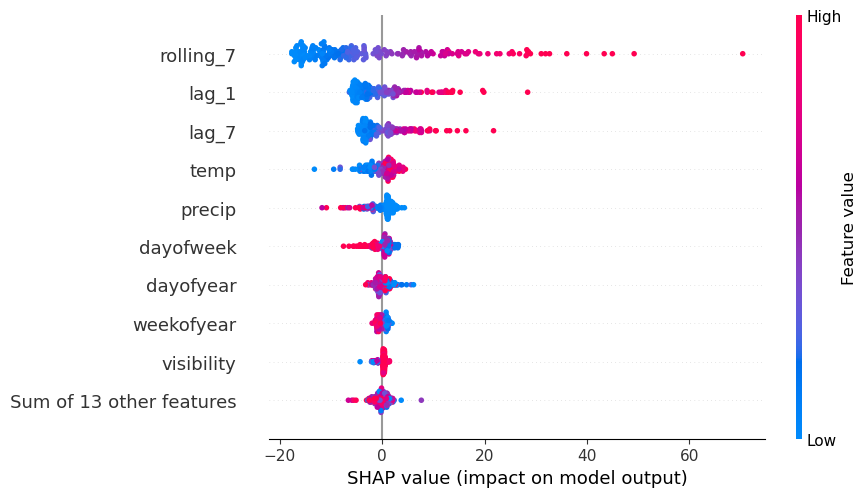

In [135]:
import shaps

explainer = shap.Explainer(model)
shap_values = explainer(X_train.sample(200))  # subset to keep it fast
shap.plots.beeswarm(shap_values)

In [100]:
"""import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Pick one station for analysis
station_id = 'A32064'
df_station = daily_station_demand[daily_station_demand['start_station_id'] == station_id]

# Ensure time index
df_station = df_station.set_index('date').sort_index()

# Plot autocorrelation of trip count
plot_acf(df_station['trip_count'], lags=30)
plt.title(f'Autocorrelation for Station {station_id}')
plt.show()"""

"import matplotlib.pyplot as plt\nfrom statsmodels.graphics.tsaplots import plot_acf\n\n# Pick one station for analysis\nstation_id = 'A32064'\ndf_station = daily_station_demand[daily_station_demand['start_station_id'] == station_id]\n\n# Ensure time index\ndf_station = df_station.set_index('date').sort_index()\n\n# Plot autocorrelation of trip count\nplot_acf(df_station['trip_count'], lags=30)\nplt.title(f'Autocorrelation for Station {station_id}')\nplt.show()"